<a href="https://colab.research.google.com/github/metacount/MachineLearning/blob/main/Machine_Learning_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home

In [ ]:
from google.colab import drive
import pandas as pd
import os
import json
from importlib import reload
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/MyDrive/HomeCredit/'
os.chdir(root_dir)
import numpy as np
import eda as eda
import aggregations as aggs
import shutil
import machine_learning as ml
from hyperopt import hp
import joblib

pid = 'SK_ID_CURR'
sid1 = 'SK_ID_BUREAU'
sid2 = 'SK_ID_PREV'
id_columns = [pid,sid1,sid2]
functions = ['mean', 'min', 'max', 'std', 'median','sum']
csv_dir = 'csv/historical/'
agg_dir = 'csv/aggregated/'
sec_id_files = ['bureau_balance.csv']
id_file = 'bureau.csv'
csv_dir = 'csv/historical/'
clean_app_file = 'csv/applications_clean.csv'
target = 'TARGET'
corr_matrix_path = 'csv/corr_matrix.csv'
clf_dir = 'clasifiers/'
merged_file = 'csv/merged.csv'

base_params = {
    'objective': 'binary',
    'metric': 'auc',
    'force_row_wise':'true',
    'is_unbalance': True,
    'early_stopping_rounds': 10,
    'verbose':-1
}

Mounted at /content/gdrive


This is classifcation task where 1 represnts loan that was rejected and 0 accpeted. Light gradient boosting algorithm is used.

# Base model

In [ ]:
df = pd.read_csv('csv/applications.csv')
df = ml.create_categorical(df)

In [ ]:
clf = ml.classifier(df, base_params, target, 'LGB Base')

0.6796843209988104


# HP tuning

In [ ]:
clf = joblib.load('classifiers/LGB Base.pkl')

In [ ]:
search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 150, 2),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 2),
}
fixed_params = clf.get_params()
combined_params = ml.hyper_parameter_tuning(df[selected],
                                        fixed_params,
                                        search_space,
                                        target)

100%|██████████| 20/20 [02:24<00:00,  7.23s/trial, best loss: -0.7448796941361748]


In [ ]:
clf = ml.classifier(df, combined_params, target, 'LGB HP S42')

0.7438314042621517


# Feature Engineering

In [ ]:
df[df['AMT_INCOME_TOTAL'] > 29269237]['AMT_INCOME_TOTAL']

171426    117000000.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [ ]:
df_cleaned = df.drop(index=171426)

In [ ]:
eda.to_csv(clean_app_file,df_cleaned)

Get curr id for table with secondary id

In [ ]:
aggs.add_ids(root_dir,csv_dir,id_file,sec_id_files,pid,sid1)

Create aggregated tables on primary id

In [ ]:
csv_files = aggs.get_csv(root_dir,csv_dir,sec_id_files)
aggs.aggregate_tables(root_dir, csv_files,
                      csv_dir,agg_dir, functions, id_columns)

Merge tables

In [ ]:
agg_csv_files =  aggs.get_csv(root_dir,agg_dir,sec_id_files)
aggs.merge_dfs(root_dir,agg_dir, clean_app_file, agg_csv_files, pid)

# Feature Selection

In [ ]:
df = pd.read_csv('merged.csv')

## Correlation

In [ ]:
numerical_df = df.select_dtypes(include='number')
corr_matrix = eda.corr_matrix(numerical_df)

In [ ]:
eda.to_csv(corr_matrix_path,corr_matrix)

In [ ]:
corr_matrix = pd.read_csv(corr_matrix_path)

In [ ]:
corr_features = eda.corr_features(corr_matrix,0.7)

## Importance

In [ ]:
lgbc = ml.load_lgb_clasifier(clf_dir+'lgbMerged.txt')

In [ ]:
feature_columns = lgbc.feature_name()

In [ ]:
feature_importance = ml.feature_importance(lgbc,feature_columns)

## Selection

In [ ]:
df = pd.read_csv('merged.csv')
df = ml.create_categorical(df)
df = ml.sanitize(df)

In [ ]:
clf = ml.classifier(df,base_params,target,'merged')z

0.7680288908371318


In [ ]:
importance = ml.feature_importance(clf)
important_features = importance[importance['Importance']>0]
feature_list = important_features['Feature'].tolist()
feature_list.append(target)
selected = ml.selected_features(corr_features,
                            feature_importance,0.9,2)
df_selected = df[selected]


In [ ]:
clf = ml.classifier(df[feature_list],base_params,target,'selected401')

0.7680291493438235


In [ ]:
search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 150, 2),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 2),

}
clf401 = joblib.load('classifiers/selected401.pkl')
fixed_params = clf.get_params()
combined_params = ml.hyper_parameter_tuning(df,
                                        fixed_params,
                                        search_space,
                                        target)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': None, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'auc', 'force_row_wise': 'true', 'is_unbalance': True, 'verbose': -1, 'n_estimators': 116, 'num_leaves': 46}
100%|██████████| 1/1 [01:05<00:00, 65.96s/trial, best loss: -0.7676323318778707]


In [ ]:
X_train, X_test, y_train, y_test = ml.create_splits(df,target)
clf = ml.lgb.LGBMClassifier(**combined_params)
clf401.fit(X_train, y_train)
ml.roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

0.7791853919241858

In [ ]:
joblib.dump(clf, 'classifiers/final_v01.pkl')

['classifiers/final_v01.pkl']

In [ ]:
clf = ml.lgb.LGBMClassifier(**base_params)
clf.fit(X_train, y_train)
ml.roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

0.7794654678026096

In [ ]:
clf = ml.lgb.LGBMClassifier(**combined_params)
clf.fit(X_train, y_train)
ml.roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

0.780134732011726

# Advanced Hyper Parameter tuning

In [ ]:
clf = joblib.load(root_dir+'classifiers/final_v01.pkl')

In [ ]:
df = pd.read_csv('csv/selected401')

In [ ]:
search_space = {
    'bagging_fraction': hp.uniform('bagging_fraction', low=0.5, high=1.0),
    'bagging_freq': hp.quniform('bagging_freq', low=1, high=10, q=1),
    'l1_reg': hp.uniform('l1_reg', low=0.001, high=0.1),
    'l2_reg': hp.uniform('l2_reg', low=0.001, high=0.1),
    'n_estimators': hp.quniform('n_estimators', 50, 250, 1),
    'num_leaves': hp.quniform('num_leaves', 16, 256, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', low=5,
                                    high=300, q=1),
}
name = '401BaseHP7'
fixed_params = clf.get_params()
combined_params = ml.hyper_parameter_tuning(df,
                                        base_params,
                                        search_space,
                                        target,
                                        name)

 96%|█████████▌| 48/50 [41:57<01:51, 55.97s/trial, best loss: -0.7692205388284402]

In [ ]:
combined_params.pop('bagging_fraction')

0

In [ ]:
ml.classifier(df,base_params,target,'401Base')

In [ ]:
ml.classifier(df,combined_params,target,'401BaseHP7')

# Test script



In [ ]:
ml.submission_classifier(df, clf401BaseHP7, target, '401BaseHP7v01Sub')

In [ ]:
test_merged = aggs.merge_dfs(root_dir,agg_dir,
                             'csv/distinct_application_test.csv',
                             csv_files,pid)

In [ ]:
test_merged = pd.read_csv('csv/merged.csv')
test_merged = ml.sanitize(test_merged)
clf = joblib.load('classifiers/final_v01.pkl')
params = clf.get_params()
df = pd.read_csv('merged.csv')
test_merged = ml.create_categorical(test_merged)
df = ml.sanitize(df)
df = ml.create_categorical(df)

test_clf = ml.lgb.LGBMClassifier(**params)
test_clf.fit(df.drop(target, axis=1),df[target])

predictions = test_clf.predict_proba(test_merged)

results = pd.concat([test_merged[pid],
                     pd.DataFrame(predictions[:, 1],
                                  columns=[target])],axis=1)
results.to_csv('predictions_v01.csv', index=False)

# Explore classifier predictions

    Precision proportion of positive predictions that were actually correct.
    Recall proportion of actual positive cases that were correctly identified.
    F1-score is the harmonic mean between precision & recall.
    Support is the total number of true instances for a particular class.

    

In [ ]:
clf = joblib.load('classifiers/final_v01.pkl')
df=ml.create_categorical(df)
X, y, X_test, y_test = ml.train_val_split(df, target)


In [ ]:
ml.get_results('classifiers/lgbApp.json')

classification_report
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56440
           1       0.18      0.62      0.28      5063

    accuracy                           0.74     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.89      0.74      0.79     61503

confusion_matrix
[[42096, 14344], [1899, 3164]]
roc_auc_score
0.6853899687467324


In [ ]:
ml.get_results('classifiers/lgbMerged.json')

classification_report
              precision    recall  f1-score   support

       False       0.96      0.77      0.85     56537
        True       0.20      0.65      0.30      4965

    accuracy                           0.76     61502
   macro avg       0.58      0.71      0.58     61502
weighted avg       0.90      0.76      0.81     61502

confusion_matrix
[[43314, 13223], [1733, 3232]]
roc_auc_score
0.7085372302332967


In [ ]:
ml.get_results('classifiers/401BaseHP7v01_eval.json')

classification_report
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     59365
           1       0.18      0.66      0.29      5213

    accuracy                           0.73     64578
   macro avg       0.57      0.70      0.56     64578
weighted avg       0.90      0.73      0.79     64578

confusion_matrix
[[43905, 15460], [1749, 3464]]
roc_auc_score
0.7020349032827102


Future tasks:

hyperparameter tuning with bigger number of rounds to explore classifier to its limits.

In [ ]:
clf = joblib.load('classifiers/final_v01.pkl')

In [ ]:
ml.feature_importance(clf)

,Feature,Importance
0,ORGANIZATION_TYPE,433
1,EXT_SOURCE_1,83
2,EXT_SOURCE_2,77
3,EXT_SOURCE_3,68
4,AMT_CREDIT,60
...,...,...
257,NAME_GOODS_CATEGORY_ConstructionMaterials,0
328,NAME_CLIENT_TYPE_New,0
327,AMT_BALANCE_sum,0
325,AMT_APPLICATION_sum,0


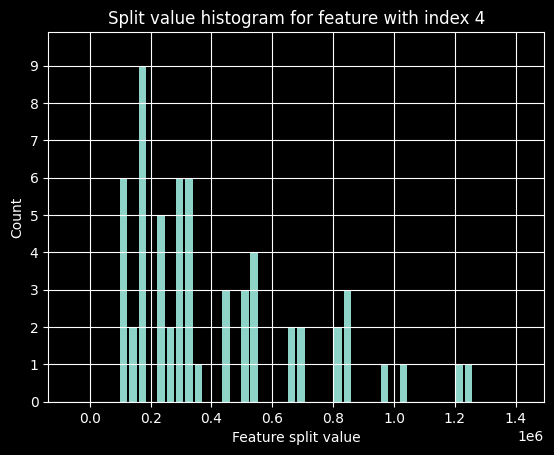

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
feature_index = 4
lgb.plot_split_value_histogram(clf, feature=feature_index)
plt.show()